In [1]:
import os
import glob
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature
import seaborn as sns

import wrf
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.colors

import matplotlib as mpl

from metpy import calc as mpcalc

In [2]:
######################
# FUNCTIONS
######################

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
######################
# CHARGE PROCESSES
print('Charging Ant hist...')

#Parameters
folder_mod = '/capstor/scratch/cscs/gsergi/OUTPUT_PGW_20220315/ANT_20220315_'
domain = 'd01'
acc_t = 1440 #minutes
ini_date_idx=0
#end_date_idx=0

###load data###
outhist_files = '/outhist/outhist_'+domain+'_*'# Load netcdf

################
#hist
wrflist_oh = []
proj = 'hist'
print('Total: ' + str(np.size(glob.glob(folder_mod+proj+outhist_files))))
for i,ncdf_oh in enumerate(np.sort(glob.glob(folder_mod+proj+outhist_files))):
        print(i, end="\r")
        wrflist_oh.append(netCDF4.Dataset(ncdf_oh))
    
# Get surface variables
t2_ant_hist = wrf.getvar(wrflist_oh, 'T2', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:] - 273.15

# Extract the pressure, geopotential height, and wind variables
Ppertubation_ant_hist = wrf.getvar(wrflist_oh, 'P', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
PB_ant_hist = wrf.getvar(wrflist_oh, 'PB', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
P_ant_hist = (Ppertubation_ant_hist + PB_ant_hist)

PHperturbation_ant_hist = wrf.getvar(wrflist_oh, 'PH', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
PHB_ant_hist = wrf.getvar(wrflist_oh, 'PHB', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
Z_ant_hist = (PHperturbation_ant_hist + PHB_ant_hist)/9.8
Z_ant_hist_unstg = wrf.destagger(Z_ant_hist, stagger_dim=1)

#P_HYD_ant_hist = wrf.getvar(wrflist_oh, 'P_HYD', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
Q_ant_hist = wrf.getvar(wrflist_oh, 'QVAPOR', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
PT_ant_hist = wrf.getvar(wrflist_oh, 'T', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:] + 270
T_ant_hist = PT_ant_hist * (P_ant_hist/100000)**0.286
U_ant_hist = wrf.getvar(wrflist_oh, 'U', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
V_ant_hist = wrf.getvar(wrflist_oh, 'V', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
W_ant_hist = wrf.getvar(wrflist_oh, 'W', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
U_ant_hist_unstg = wrf.destagger(U_ant_hist, stagger_dim=3)
V_ant_hist_unstg = wrf.destagger(V_ant_hist, stagger_dim=2)
W_ant_hist_unstg = wrf.destagger(W_ant_hist, stagger_dim=1)

#Calculate variables in pressure levels
g = 9.81 #m/s2
rgas = 287.058 # J/(kg-K) => m2/(s2 K)

P_sig2_hist = P_ant_hist[:,2,:,:]
Z_sig2_hist = Z_ant_hist_unstg[:,2,:,:]
Q_sig2_hist = Q_ant_hist[:,2,:,:]
T_sig2_hist = T_ant_hist[:,2,:,:]
PT_sig2_hist = PT_ant_hist[:,2,:,:]
U_sig2_hist = U_ant_hist_unstg[:,2,:,:]
V_sig2_hist = V_ant_hist_unstg[:,2,:,:]
W_sig2_hist = W_ant_hist_unstg[:,2,:,:]
T_sig1_hist = T_ant_hist[:,1,:,:]
T_sig3_hist = T_ant_hist[:,3,:,:]
Z_sig1_hist = Z_ant_hist[:,1,:,:]
Z_sig3_hist = Z_ant_hist[:,3,:,:]
PT_sig1_hist = PT_ant_hist[:,1,:,:]
PT_sig3_hist = PT_ant_hist[:,3,:,:]
Q_sig1_hist = Q_ant_hist[:,1,:,:]
Q_sig3_hist = Q_ant_hist[:,3,:,:]
P_sig1_hist = P_ant_hist[:,1,:,:]
P_sig3_hist = P_ant_hist[:,3,:,:]
Rho_sig2_hist  = P_sig2_hist/(rgas*T_sig2_hist)
Omega_sig2_hist = - W_sig2_hist * Rho_sig2_hist * g

P_sig25_hist = P_ant_hist[:,25,:,:]
Z_sig25_hist = Z_ant_hist_unstg[:,25,:,:]
Q_sig25_hist = Q_ant_hist[:,25,:,:]
T_sig25_hist = T_ant_hist[:,25,:,:]
PT_sig25_hist = PT_ant_hist[:,25,:,:]
U_sig25_hist = U_ant_hist_unstg[:,25,:,:]
V_sig25_hist = V_ant_hist_unstg[:,25,:,:]
W_sig25_hist = W_ant_hist_unstg[:,25,:,:]
T_sig24_hist = T_ant_hist[:,24,:,:]
T_sig26_hist = T_ant_hist[:,26,:,:]
Z_sig24_hist = Z_ant_hist[:,24,:,:]
Z_sig26_hist = Z_ant_hist[:,26,:,:]
PT_sig24_hist = PT_ant_hist[:,24,:,:]
PT_sig26_hist = PT_ant_hist[:,26,:,:]
Q_sig24_hist = Q_ant_hist[:,24,:,:]
Q_sig26_hist = Q_ant_hist[:,26,:,:]
P_sig24_hist = P_ant_hist[:,24,:,:]
P_sig26_hist = P_ant_hist[:,26,:,:]
Rho_sig25_hist  = P_sig25_hist/(rgas*T_sig25_hist)
Omega_sig25_hist = - W_sig25_hist * Rho_sig25_hist * g


################
#past
wrflist_oh = []
proj = 'past_new'
print('Total: ' + str(np.size(glob.glob(folder_mod+proj+outhist_files))))
for i,ncdf_oh in enumerate(np.sort(glob.glob(folder_mod+proj+outhist_files))):
        print(i, end="\r")
        wrflist_oh.append(netCDF4.Dataset(ncdf_oh))
    
# Get surface variables
t2_ant_hist = wrf.getvar(wrflist_oh, 'T2', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:] - 273.15

# Extract the pressure, geopotential height, and wind variables
Ppertubation_ant_past = wrf.getvar(wrflist_oh, 'P', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
PB_ant_past = wrf.getvar(wrflist_oh, 'PB', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
P_ant_past = (Ppertubation_ant_past + PB_ant_past)

PHperturbation_ant_past = wrf.getvar(wrflist_oh, 'PH', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
PHB_ant_past = wrf.getvar(wrflist_oh, 'PHB', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
Z_ant_past = (PHperturbation_ant_past + PHB_ant_past)/9.8
Z_ant_past_unstg = wrf.destagger(Z_ant_past, stagger_dim=1)

#P_HYD_ant_hist = wrf.getvar(wrflist_oh, 'P_HYD', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
Q_ant_past = wrf.getvar(wrflist_oh, 'QVAPOR', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
PT_ant_past = wrf.getvar(wrflist_oh, 'T', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:] + 270
T_ant_past = PT_ant_past * (P_ant_past/100000)**0.286
U_ant_past = wrf.getvar(wrflist_oh, 'U', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
V_ant_past = wrf.getvar(wrflist_oh, 'V', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
W_ant_past = wrf.getvar(wrflist_oh, 'W', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:,:]
U_ant_past_unstg = wrf.destagger(U_ant_past, stagger_dim=3)
V_ant_past_unstg = wrf.destagger(V_ant_past, stagger_dim=2)
W_ant_past_unstg = wrf.destagger(W_ant_past, stagger_dim=1)

#Calculate variables in pressure levels
g = 9.81 #m/s2
rgas = 287.058 # J/(kg-K) => m2/(s2 K)

P_sig2_past = P_ant_past[:,2,:,:]
Z_sig2_past = Z_ant_past_unstg[:,2,:,:]
Q_sig2_past = Q_ant_past[:,2,:,:]
T_sig2_past = T_ant_past[:,2,:,:]
PT_sig2_past = PT_ant_past[:,2,:,:]
U_sig2_past = U_ant_past_unstg[:,2,:,:]
V_sig2_past = V_ant_past_unstg[:,2,:,:]
W_sig2_past = W_ant_past_unstg[:,2,:,:]
T_sig1_past = T_ant_past[:,1,:,:]
T_sig3_past = T_ant_past[:,3,:,:]
Z_sig1_past = Z_ant_past[:,1,:,:]
Z_sig3_past = Z_ant_past[:,3,:,:]
PT_sig1_past = PT_ant_past[:,1,:,:]
PT_sig3_past = PT_ant_past[:,3,:,:]
Q_sig1_past = Q_ant_past[:,1,:,:]
Q_sig3_past = Q_ant_past[:,3,:,:]
P_sig1_past = P_ant_past[:,1,:,:]
P_sig3_past = P_ant_past[:,3,:,:]
Rho_sig2_past  = P_sig2_past/(rgas*T_sig2_past)
Omega_sig2_past = - W_sig2_past * Rho_sig2_past * g

P_sig25_past = P_ant_past[:,25,:,:]
Z_sig25_past = Z_ant_past_unstg[:,25,:,:]
Q_sig25_past = Q_ant_past[:,25,:,:]
T_sig25_past = T_ant_past[:,25,:,:]
PT_sig25_past = PT_ant_past[:,25,:,:]
U_sig25_past = U_ant_past_unstg[:,25,:,:]
V_sig25_past = V_ant_past_unstg[:,25,:,:]
W_sig25_past = W_ant_past_unstg[:,25,:,:]
T_sig24_past = T_ant_past[:,24,:,:]
T_sig26_past = T_ant_past[:,26,:,:]
Z_sig24_past = Z_ant_past[:,24,:,:]
Z_sig26_past = Z_ant_past[:,26,:,:]
PT_sig24_past = PT_ant_past[:,24,:,:]
PT_sig26_past = PT_ant_past[:,26,:,:]
Q_sig24_past = Q_ant_past[:,24,:,:]
Q_sig26_past = Q_ant_past[:,26,:,:]
P_sig24_past = P_ant_past[:,24,:,:]
P_sig26_past = P_ant_past[:,26,:,:]
Rho_sig25_past  = P_sig25_past/(rgas*T_sig25_past)
Omega_sig25_past = - W_sig25_past * Rho_sig25_past * g

    
######################
# ANT COORDINATES
# Get surface fix variables
height = wrf.getvar(wrflist_oh, 'HGT', timeidx=0, method="cat")[:,:]
# Get dimension
lats, lons = wrf.latlon_coords(t2_ant_hist)
x, y = wrf.ll_to_xy(wrflist_oh, lons, lats)
times = wrf.extract_times(wrflist_oh, timeidx=wrf.ALL_TIMES)

Charging Ant hist...
Total: 59
Total: 59


/users/gsergi/miniconda3/lib/python3.9/site-packages/wrf/latlonutils.py:434: RuntimeWarning: invalid value encountered in cast
  result = np.rint(result).astype(int)


In [4]:
########################################
#Calculate Heat Tendency Equation components (level simga = 2)
#######################################
Xdist = Ydist = 27000

#########
# hist
#Advection in horizontal axis
dT_dx = (np.diff(T_sig2_hist, axis=2)[:,:,:-1] + np.diff(T_sig2_hist, axis=2)[:,:,1:]) / (Xdist)
dT_dy = (np.diff(T_sig2_hist, axis=1)[:,:-1,:] + np.diff(T_sig2_hist, axis=1)[:,1:,:]) / (Ydist)
Adv_sig2_hist = - (U_sig2_hist[:,1:-1,1:-1]*dT_dx[:,1:-1,:] + V_sig2_hist[:,1:-1,1:-1]*dT_dy[:,:,1:-1]) *86400/24 #units deg/hour
Adv_sig2_hist = Adv_sig2_hist[1:-1,:,:]

#Advection in vertical axis
dT_dz = ((T_sig1_hist - T_sig3_hist) / (Z_sig1_hist-Z_sig3_hist))
VAdv_sig2_hist = - (W_sig2_hist[:,:,:] * dT_dz[:,:,:]) *86400/24 #units deg/hour
VAdv_sig2_hist = VAdv_sig2_hist[1:-1,1:-1,1:-1]

#Temperature Tendency
T_sig2_hist_sec = T_sig2_hist[:,1:-1,1:-1]
Tend_sig2_hist = (T_sig2_hist_sec[1:,:,:].values - T_sig2_hist_sec[:-1,:,:].values) /3 #units deg/hour

#Temperature Tendency
Res_sig2_hist = Tend_sig2_hist[:-1,:,:]- Adv_sig2_hist - VAdv_sig2_hist



#########
# past
#Advection in horizontal axis
dT_dx = (np.diff(T_sig2_past, axis=2)[:,:,:-1] + np.diff(T_sig2_past, axis=2)[:,:,1:]) / (Xdist)
dT_dy = (np.diff(T_sig2_past, axis=1)[:,:-1,:] + np.diff(T_sig2_past, axis=1)[:,1:,:]) / (Ydist)
Adv_sig2_past = - (U_sig2_past[:,1:-1,1:-1]*dT_dx[:,1:-1,:] + V_sig2_past[:,1:-1,1:-1]*dT_dy[:,:,1:-1]) *86400/24 #units deg/hour
Adv_sig2_past = Adv_sig2_past[1:-1,:,:]

#Advection in vertical axis
dT_dz = ((T_sig1_past - T_sig3_past) / (Z_sig1_past-Z_sig3_past))
VAdv_sig2_past = - (W_sig2_past[:,:,:] * dT_dz[:,:,:]) *86400/24 #units deg/hour
VAdv_sig2_past = VAdv_sig2_past[1:-1,1:-1,1:-1]

#Temperature Tendency
T_sig2_past_sec = T_sig2_past[:,1:-1,1:-1]
Tend_sig2_past = (T_sig2_past_sec[1:,:,:].values - T_sig2_past_sec[:-1,:,:].values) /3 #units deg/hour

#Temperature Tendency
Res_sig2_past = Tend_sig2_past[:-1,:,:]- Adv_sig2_past - VAdv_sig2_past

In [5]:
########################################
#Calculate Heat Tendency Equation components (level simga = 25)
#######################################
Xdist = Ydist = 27000

#########
# hist
#Advection in horizontal axis
dT_dx = (np.diff(T_sig25_hist, axis=2)[:,:,:-1] + np.diff(T_sig25_hist, axis=2)[:,:,1:]) / (Xdist)
dT_dy = (np.diff(T_sig25_hist, axis=1)[:,:-1,:] + np.diff(T_sig25_hist, axis=1)[:,1:,:]) / (Ydist)
Adv_sig25_hist = - (U_sig25_hist[:,1:-1,1:-1]*dT_dx[:,1:-1,:] + V_sig25_hist[:,1:-1,1:-1]*dT_dy[:,:,1:-1]) *86400/24 #units deg/hour
Adv_sig25_hist = Adv_sig25_hist[1:-1,:,:]

#Advection in vertical axis
dT_dz = ((T_sig24_hist - T_sig26_hist) / (Z_sig24_hist-Z_sig26_hist))
VAdv_sig25_hist = - (W_sig25_hist[:,:,:] * dT_dz[:,:,:]) *86400/24 #units deg/hour
VAdv_sig25_hist = VAdv_sig25_hist[1:-1,1:-1,1:-1]

#Temperature Tendency
T_sig25_hist_sec = T_sig25_hist[:,1:-1,1:-1]
Tend_sig25_hist = (T_sig25_hist_sec[1:,:,:].values - T_sig25_hist_sec[:-1,:,:].values) /3 #units deg/hour

#Temperature Tendency
Res_sig25_hist = Tend_sig25_hist[:-1,:,:]- Adv_sig25_hist - VAdv_sig25_hist



#########
# past
#Advection in horizontal axis
dT_dx = (np.diff(T_sig25_past, axis=2)[:,:,:-1] + np.diff(T_sig25_past, axis=2)[:,:,1:]) / (Xdist)
dT_dy = (np.diff(T_sig25_past, axis=1)[:,:-1,:] + np.diff(T_sig25_past, axis=1)[:,1:,:]) / (Ydist)
Adv_sig25_past = - (U_sig25_past[:,1:-1,1:-1]*dT_dx[:,1:-1,:] + V_sig25_past[:,1:-1,1:-1]*dT_dy[:,:,1:-1]) *86400/24 #units deg/hour
Adv_sig25_past = Adv_sig25_past[1:-1,:,:]

#Advection in vertical axis
dT_dz = ((T_sig24_past - T_sig26_past) / (Z_sig24_past-Z_sig26_past))
VAdv_sig25_past = - (W_sig25_past[:,:,:] * dT_dz[:,:,:]) *86400/24 #units deg/hour
VAdv_sig25_past = VAdv_sig25_past[1:-1,1:-1,1:-1]

#Temperature Tendency
T_sig25_past_sec = T_sig25_past[:,1:-1,1:-1]
Tend_sig25_past = (T_sig25_past_sec[1:,:,:].values - T_sig25_past_sec[:-1,:,:].values) /3 #units deg/hour

#Temperature Tendency
Res_sig25_past = Tend_sig25_past[:-1,:,:]- Adv_sig25_past - VAdv_sig25_past

In [6]:
########################################
#Calculate Moisture Tendency Equation components (level simga = 2)
#######################################
Xdist = Ydist = 27000

#########
# hist
#Advection in horizontal axis
dQ_dx = (np.diff(Q_sig2_hist*1000, axis=2)[:,:,:-1] + np.diff(Q_sig2_hist*1000, axis=2)[:,:,1:]) / (Xdist)
dQ_dy = (np.diff(Q_sig2_hist*1000, axis=1)[:,:-1,:] + np.diff(Q_sig2_hist*1000, axis=1)[:,1:,:]) / (Ydist)
AdvQ_sig2_hist = - (U_sig2_hist[:,1:-1,1:-1]*dQ_dx[:,1:-1,:] + V_sig2_hist[:,1:-1,1:-1]*dQ_dy[:,:,1:-1]) *86400/24 #units kg/kg/hour
AdvQ_sig2_hist = AdvQ_sig2_hist[1:-1,:,:]

#Advection in vertical axis
dQ_dz = ((Q_sig1_hist*1000 - Q_sig3_hist*1000) / (Z_sig1_hist-Z_sig3_hist))
VAdvQ_sig2_hist = - (W_sig2_hist[:,:,:] * dQ_dz[:,:,:]) *86400/24 #units kg/kg/hour
VAdvQ_sig2_hist = VAdvQ_sig2_hist[1:-1,1:-1,1:-1]

#Moisture Tendency
Q_sig2_hist_sec = Q_sig2_hist[:,1:-1,1:-1]*1000
TendQ_sig2_hist = (Q_sig2_hist_sec[1:,:,:].values - Q_sig2_hist_sec[:-1,:,:].values) /3 #units kg/kg/hour

#Temperature Tendency
ResQ_sig2_hist = TendQ_sig2_hist[:-1,:,:]- AdvQ_sig2_hist - VAdvQ_sig2_hist



#########
# past
#Advection in horizontal axis
dQ_dx = (np.diff(Q_sig2_past*1000, axis=2)[:,:,:-1] + np.diff(Q_sig2_past*1000, axis=2)[:,:,1:]) / (Xdist)
dQ_dy = (np.diff(Q_sig2_past*1000, axis=1)[:,:-1,:] + np.diff(Q_sig2_past*1000, axis=1)[:,1:,:]) / (Ydist)
AdvQ_sig2_past = - (U_sig2_past[:,1:-1,1:-1]*dQ_dx[:,1:-1,:] + V_sig2_past[:,1:-1,1:-1]*dQ_dy[:,:,1:-1]) *86400/24 #units kg/kg/hour
AdvQ_sig2_past = AdvQ_sig2_past[1:-1,:,:]

#Advection in vertical axis
dQ_dz = ((Q_sig1_past*1000 - Q_sig3_past*1000) / (Z_sig1_past-Z_sig3_past))
VAdvQ_sig2_past = - (W_sig2_past[:,:,:] * dQ_dz[:,:,:]) *86400/24 #units kg/kg/hour
VAdvQ_sig2_past = VAdvQ_sig2_past[1:-1,1:-1,1:-1]

#Temperature Tendency
Q_sig2_past_sec = Q_sig2_past[:,1:-1,1:-1]*1000
TendQ_sig2_past = (Q_sig2_past_sec[1:,:,:].values - Q_sig2_past_sec[:-1,:,:].values) /3 #units kg/kg/hour

#Temperature Tendency
ResQ_sig2_past = TendQ_sig2_past[:-1,:,:]- AdvQ_sig2_past - VAdvQ_sig2_past

In [7]:
########################################
#Calculate Moisture Tendency Equation components (level simga = 25)
#######################################
Xdist = Ydist = 27000

#########
# hist
#Advection in horizontal axis
dQ_dx = (np.diff(Q_sig25_hist*1000, axis=2)[:,:,:-1] + np.diff(Q_sig25_hist*1000, axis=2)[:,:,1:]) / (Xdist)
dQ_dy = (np.diff(Q_sig25_hist*1000, axis=1)[:,:-1,:] + np.diff(Q_sig25_hist*1000, axis=1)[:,1:,:]) / (Ydist)
AdvQ_sig25_hist = - (U_sig25_hist[:,1:-1,1:-1]*dQ_dx[:,1:-1,:] + V_sig25_hist[:,1:-1,1:-1]*dQ_dy[:,:,1:-1]) *86400/24 #units kg/kg/hour
AdvQ_sig25_hist = AdvQ_sig25_hist[1:-1,:,:]

#Advection in vertical axis
dQ_dp = ((Q_sig24_hist*1000 - Q_sig26_hist*1000) / (P_sig24_hist-P_sig26_hist))
VAdvQ_sig25_hist = - (Omega_sig25_hist[:,:,:] * dQ_dp[:,:,:]) *86400/24 #units kg/kg/hour
VAdvQ_sig25_hist = VAdvQ_sig25_hist[1:-1,1:-1,1:-1]

#Moisture Tendency
Q_sig25_hist_sec = Q_sig25_hist[:,1:-1,1:-1]*1000
TendQ_sig25_hist = (Q_sig25_hist_sec[1:,:,:].values - Q_sig25_hist_sec[:-1,:,:].values) /3 #units kg/kg/hour

#Temperature Tendency
ResQ_sig25_hist = TendQ_sig25_hist[:-1,:,:]- AdvQ_sig25_hist - VAdvQ_sig25_hist



#########
# past
#Advection in horizontal axis
dQ_dx = (np.diff(Q_sig25_past*1000, axis=2)[:,:,:-1] + np.diff(Q_sig25_past*1000, axis=2)[:,:,1:]) / (Xdist)
dQ_dy = (np.diff(Q_sig25_past*1000, axis=1)[:,:-1,:] + np.diff(Q_sig25_past*1000, axis=1)[:,1:,:]) / (Ydist)
AdvQ_sig25_past = - (U_sig25_past[:,1:-1,1:-1]*dQ_dx[:,1:-1,:] + V_sig25_past[:,1:-1,1:-1]*dQ_dy[:,:,1:-1]) *86400/24 #units kg/kg/hour
AdvQ_sig25_past = AdvQ_sig25_past[1:-1,:,:]

#Advection in vertical axis
dQ_dp = ((Q_sig24_past*1000 - Q_sig26_past*1000) / (P_sig24_past-P_sig26_past))
VAdvQ_sig25_past = - (Omega_sig25_past[:,:,:] * dQ_dp[:,:,:]) *86400/24 #units kg/kg/hour
VAdvQ_sig25_past = VAdvQ_sig25_past[1:-1,1:-1,1:-1]

#Temperature Tendency
Q_sig25_past_sec = Q_sig25_past[:,1:-1,1:-1]*1000
TendQ_sig25_past = (Q_sig25_past_sec[1:,:,:].values - Q_sig25_past_sec[:-1,:,:].values) /3 #units kg/kg/hour

#Temperature Tendency
ResQ_sig25_past = TendQ_sig25_past[:-1,:,:]- AdvQ_sig25_past - VAdvQ_sig25_past

In [8]:
#Positions
CON_xy = wrf.ll_to_xy(wrflist_oh, -75.09978, 123.332196) #Concordia
CON_ll = wrf.xy_to_ll(wrflist_oh, CON_xy[0], CON_xy[1])
DDU_xy = wrf.ll_to_xy(wrflist_oh, -66.662778, 140.001111) #DDU
DDU_ll = wrf.xy_to_ll(wrflist_oh, DDU_xy[0], DDU_xy[1])
CIS_xy = wrf.ll_to_xy(wrflist_oh, -66.033333, 103.55) #DDU
CIS_ll = wrf.xy_to_ll(wrflist_oh, CIS_xy[0], CIS_xy[1])

[]

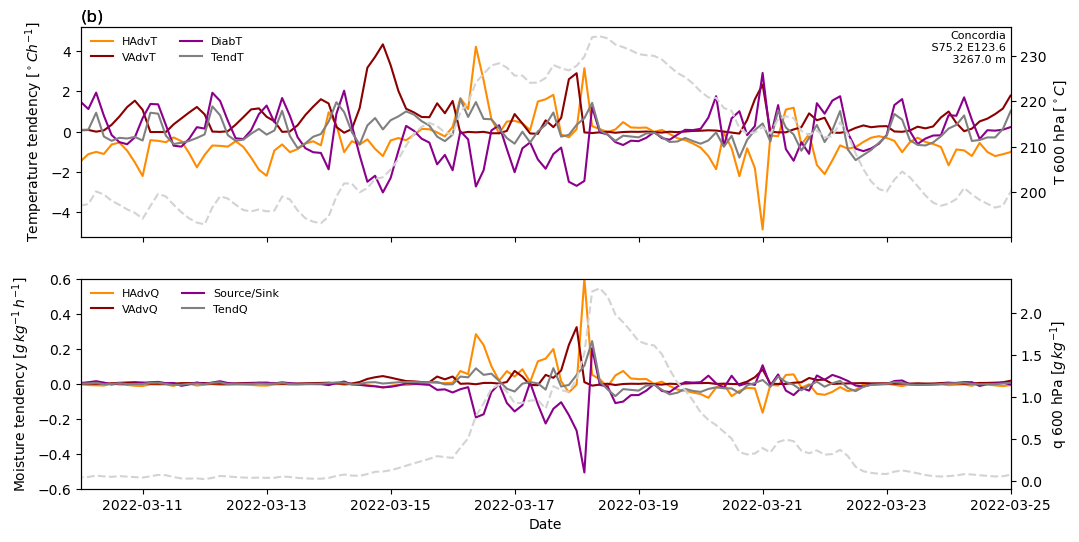

In [9]:
#############################################
# Plot Temperature and Moisture Tendency components at Concordia
#############################################

#Times Timeseries
tiniTS = np.where(times == np.datetime64('2022-03-10T00'))[0][0]
tendTS = np.where(times == np.datetime64('2022-03-25T00'))[0][0]

font = {'family' : 'normal','weight' : 'normal'}  

#Figure and axis
fig, (ax1, ax2)  = plt.subplots(2, 1, sharey=False, sharex=True, gridspec_kw={'hspace': 0.2, 'wspace':0.3}, figsize=(12,6), facecolor='white')

ax1b = ax1.twinx()
ax2b = ax2.twinx()

#Concordia Temp
ax1.plot(times[1:-1], Adv_sig2_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkOrange', label='HAdvT')
ax1.plot(times[1:-1], VAdv_sig2_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkRed', label='VAdvT')
ax1.plot(times[1:-1], Res_sig2_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkMagenta', label='DiabT')
ax1.plot(times[1:-1], Tend_sig2_hist[:-1, CON_xy[1]-1, CON_xy[0]-1], '-', c='Gray', label='TendT')

ax1b.plot(times[1:-1], T_sig2_hist[1:-1, CON_xy[1], CON_xy[0]], '--', color='LightGray', label='T600')

ax1.text(0, 1.01, '(b)', horizontalalignment='left', verticalalignment='bottom', transform=ax1.transAxes, fontsize=12)
ax1.legend(ncol=2, loc='upper left', frameon=False, fontsize=8)

#Concordia Q
ax2.plot(times[1:-1], AdvQ_sig2_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkOrange', label='HAdvQ')
ax2.plot(times[1:-1], VAdvQ_sig2_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkRed', label='VAdvQ')
ax2.plot(times[1:-1], ResQ_sig2_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkMagenta', label='Source/Sink')
ax2.plot(times[1:-1], TendQ_sig2_hist[:-1, CON_xy[1]-1, CON_xy[0]-1], '-', c='Gray', label='TendQ')

ax2b.plot(times[1:-1], Q_sig2_hist[1:-1, CON_xy[1], CON_xy[0]]*1000, '--', color='LightGray', label='Q600')

ax2.text(0, 1.01, '(b)', horizontalalignment='left', verticalalignment='bottom', transform=ax1.transAxes, fontsize=12)
ax2.legend(ncol=2, loc='upper left', frameon=False, fontsize=8)

#Label
ax1.text(.995, .98, 'Concordia' + '\n S' + str(-np.round(CON_ll[0].values,1)) + ' E' + str(np.round(CON_ll[1].values,1)) + '\n ' + str(np.round(height[CON_xy[1], CON_xy[0]].values, 0)) + ' m',
    horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes, fontsize=8)

#Plot parameters
ax2.set_xlabel('Date')
ax1.set_ylabel('Temperature tendency [$^\circ C h^{-1}$]')
ax2.set_ylabel('Moisture tendency [$g\, kg^{-1}\, h^{-1}$]')
ax1b.set_ylabel('T 600 hPa [$^\circ C$]')
ax2b.set_ylabel('q 600 hPa [$g\, kg^{-1}$]')
ax1.set_xlim(times[tiniTS], times[tendTS])

ax1.set_ylim(-5.2, 5.2)
ax2.set_ylim(-0.6, 0.6)
#ax2.set_ylim(-25, 0)
plt.plot()

[]

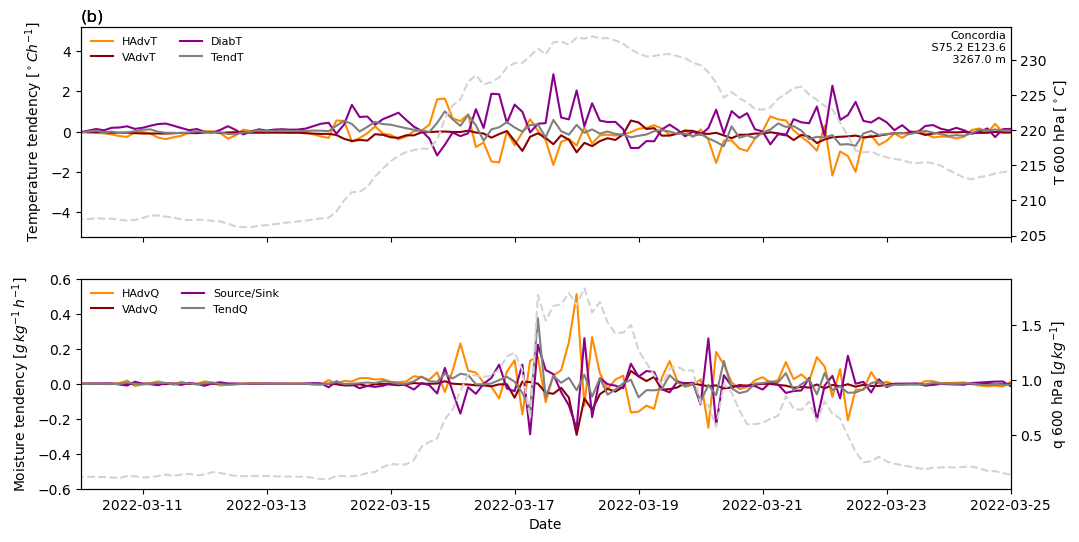

In [10]:
#############################################
# Plot Temperature and Moisture Tendency components at Concordia
#############################################

#Times Timeseries
tiniTS = np.where(times == np.datetime64('2022-03-10T00'))[0][0]
tendTS = np.where(times == np.datetime64('2022-03-25T00'))[0][0]

font = {'family' : 'normal','weight' : 'normal'}  

#Figure and axis
fig, (ax1, ax2)  = plt.subplots(2, 1, sharey=False, sharex=True, gridspec_kw={'hspace': 0.2, 'wspace':0.3}, figsize=(12,6), facecolor='white')

ax1b = ax1.twinx()
ax2b = ax2.twinx()

#Concordia Temp
ax1.plot(times[1:-1], Adv_sig25_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkOrange', label='HAdvT')
ax1.plot(times[1:-1], VAdv_sig25_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkRed', label='VAdvT')
ax1.plot(times[1:-1], Res_sig25_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkMagenta', label='DiabT')
ax1.plot(times[1:-1], Tend_sig25_hist[:-1, CON_xy[1]-1, CON_xy[0]-1], '-', c='Gray', label='TendT')

ax1b.plot(times[1:-1], T_sig25_hist[1:-1, CON_xy[1], CON_xy[0]], '--', color='LightGray', label='T600')

ax1.text(0, 1.01, '(b)', horizontalalignment='left', verticalalignment='bottom', transform=ax1.transAxes, fontsize=12)
ax1.legend(ncol=2, loc='upper left', frameon=False, fontsize=8)

#Concordia Q
ax2.plot(times[1:-1], AdvQ_sig25_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkOrange', label='HAdvQ')
ax2.plot(times[1:-1], VAdvQ_sig25_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkRed', label='VAdvQ')
ax2.plot(times[1:-1], ResQ_sig25_hist[:, CON_xy[1]-1, CON_xy[0]-1], '-', c='DarkMagenta', label='Source/Sink')
ax2.plot(times[1:-1], TendQ_sig25_hist[:-1, CON_xy[1]-1, CON_xy[0]-1], '-', c='Gray', label='TendQ')

ax2b.plot(times[1:-1], Q_sig25_hist[1:-1, CON_xy[1], CON_xy[0]]*1000, '--', color='LightGray', label='Q600')

ax2.text(0, 1.01, '(b)', horizontalalignment='left', verticalalignment='bottom', transform=ax1.transAxes, fontsize=12)
ax2.legend(ncol=2, loc='upper left', frameon=False, fontsize=8)

#Label
ax1.text(.995, .98, 'Concordia' + '\n S' + str(-np.round(CON_ll[0].values,1)) + ' E' + str(np.round(CON_ll[1].values,1)) + '\n ' + str(np.round(height[CON_xy[1], CON_xy[0]].values, 0)) + ' m',
    horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes, fontsize=8)

#Plot parameters
ax2.set_xlabel('Date')
ax1.set_ylabel('Temperature tendency [$^\circ C h^{-1}$]')
ax2.set_ylabel('Moisture tendency [$g\, kg^{-1}\, h^{-1}$]')
ax1b.set_ylabel('T 600 hPa [$^\circ C$]')
ax2b.set_ylabel('q 600 hPa [$g\, kg^{-1}$]')
ax1.set_xlim(times[tiniTS], times[tendTS])

ax1.set_ylim(-5.2, 5.2)
ax2.set_ylim(-0.6, 0.6)
#ax2.set_ylim(-25, 0)
plt.plot()

/tmp/ipykernel_158522/103059517.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(wrf.to_np(CON_xy)[0], wrf.to_np(CON_xy)[1], 'ko', markersize=5, color='k')
/users/gsergi/miniconda3/lib/python3.9/site-packages/matplotlib/quiver.py:671: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/users/gsergi/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


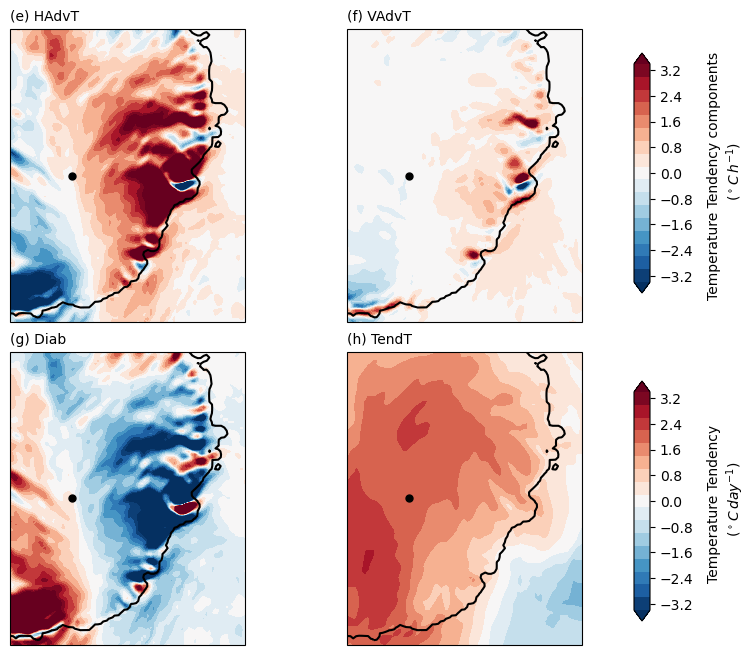

In [12]:
#############################################
# Plot terrein map
#############################################

min_height = 10

time_ix_ini = np.where(times == np.datetime64('2022-03-15T00'))[0][0]
time_ix_end = np.where(times == np.datetime64('2022-03-18T00'))[0][0]
  
#################
### Plot Norm ###
#Figure and axis
fig = plt.figure(figsize=[8,8])
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace= 0.1, wspace=0.1)

### Background
ax1 = fig.add_subplot(spec[0, 0], projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(spec[0, 1], projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(spec[1, 0], projection=ccrs.SouthPolarStereo())
ax4 = fig.add_subplot(spec[1, 1], projection=ccrs.SouthPolarStereo())

CS1 = ax1.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS2 = ax2.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS3 = ax3.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS4 = ax4.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")

for ax in [ax1, ax2, ax3, ax4]:
    ax.plot(wrf.to_np(CON_xy)[0], wrf.to_np(CON_xy)[1], 'ko', markersize=5, color='k')
    #ax.plot(wrf.to_np(DDU_xy)[0], wrf.to_np(DDU_xy)[1], 'ko', markersize=5, color='k')
    #ax.plot(wrf.to_np(CIS_xy)[0], wrf.to_np(CIS_xy)[1], 'ko', markersize=5, color='k')

#Calculate difference between the beginning and the end of the event
Adv_sig25_hist_event = wrf.to_np(Adv_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0))
VAdv_sig25_hist_event = wrf.to_np(VAdv_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0))
Res_sig25_hist_event = wrf.to_np(Res_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0))
Tend_sig25_hist_event = wrf.to_np(Tend_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0))

fill1 = ax1.contourf(Adv_sig25_hist_event, np.arange(-3.4,3.5,0.4), cmap='RdBu_r', extend="both")
Q1 = ax1.quiver(lons, lats, wrf.to_np(U_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)), wrf.to_np(V_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)), regrid_shape=30)
#qk1 = ax1.quiverkey(Q1, 
#                   1.07, 0.99,                  # x,y label position
#                   10, # choose units + update string
#                   labelpos='E',                # add label to the right
#                   coordinates='axes'
#                   )

fill2 = ax2.contourf(VAdv_sig25_hist_event, np.arange(-3.4,3.5,0.4), cmap='RdBu_r', extend="both")
#Q2 = ax2.scatter(np.where(W_500_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0) > 0.01)[0], np.where(W_500_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0) > 0.01)[1], c='k', s=1, marker='.')
#Q2 = ax2.scatter(np.where(W_500_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0) < -0.01)[0], np.where(W_500_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0) < -0.01)[1], c='k', s=1, marker='x')

fill3 = ax3.contourf(Res_sig25_hist_event, np.arange(-3.4,3.5,0.4), cmap='RdBu_r', extend="both")
fill4 = ax4.contourf(Tend_sig25_hist_event*8, np.arange(-3.4,3.5,0.4), cmap='RdBu_r', extend="both")

ax1.set_title('(e) HAdvT', loc='left', fontsize=10)
ax2.set_title('(f) VAdvT', loc='left', fontsize=10)
ax3.set_title('(g) Diab', loc='left', fontsize=10)
ax4.set_title('(h) TendT', loc='left', fontsize=10)

fig.subplots_adjust(right=0.93)
cbar_ax_1 = fig.add_axes([0.95, 0.55, 0.02, 0.3])
cbar_1 = fig.colorbar(fill1, cax=cbar_ax_1, orientation = 'vertical', shrink=0.5, pad=0)
cbar_1.set_label('Temperature Tendency components \n ($^\circ C\, h^{-1}$)', labelpad=10)
cbar_1.set_ticks(np.arange(-3.2,3.3,0.8))

cbar_ax_2 = fig.add_axes([0.95, 0.14, 0.02, 0.3])
cbar_2 = fig.colorbar(fill4, cax=cbar_ax_2, orientation = 'vertical', shrink=0.5, pad=0)
cbar_2.set_label('Temperature Tendency \n ($^\circ C\, day^{-1}$)', labelpad=10)
cbar_2.set_ticks(np.arange(-3.2,3.3,0.8))

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_extent([140, 220, 30, 130], crs=ccrs.SouthPolarStereo())
    ax.contourf(np.where(np.isnan(Res_sig2_hist_event), 1, 0), [0.1, 1000], cmap='Greys')

/tmp/ipykernel_158522/1921575899.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(wrf.to_np(CON_xy)[0], wrf.to_np(CON_xy)[1], 'ko', markersize=5, color='k')


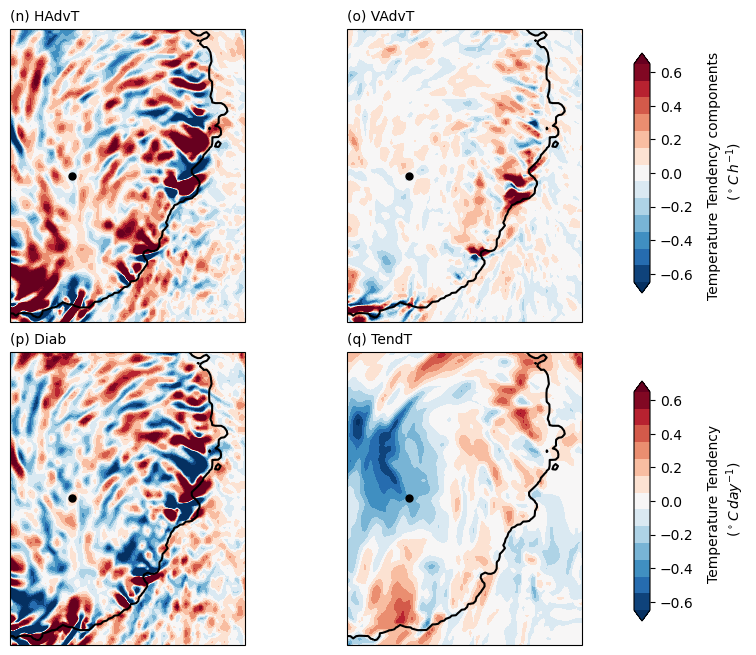

In [14]:
#############################################
# Plot Change in Temperature Tendency Equation components (level simga = 25)
#############################################

min_height = 10

time_ix_ini = np.where(times == np.datetime64('2022-03-15T00'))[0][0]
time_ix_end = np.where(times == np.datetime64('2022-03-18T00'))[0][0]
  
#################
### Plot Norm ###
#Figure and axis
fig = plt.figure(figsize=[8,8])
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace= 0.1, wspace=0.1)

### Background
ax1 = fig.add_subplot(spec[0, 0], projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(spec[0, 1], projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(spec[1, 0], projection=ccrs.SouthPolarStereo())
ax4 = fig.add_subplot(spec[1, 1], projection=ccrs.SouthPolarStereo())

CS1 = ax1.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS2 = ax2.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS3 = ax3.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS4 = ax4.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")

for ax in [ax1, ax2, ax3, ax4]:
    ax.plot(wrf.to_np(CON_xy)[0], wrf.to_np(CON_xy)[1], 'ko', markersize=5, color='k')
    #ax.plot(wrf.to_np(DDU_xy)[0], wrf.to_np(DDU_xy)[1], 'ko', markersize=5, color='k')
    #ax.plot(wrf.to_np(CIS_xy)[0], wrf.to_np(CIS_xy)[1], 'ko', markersize=5, color='k')

#Calculate difference between the beginning and the end of the event
Adv_sig25_hist_event = wrf.to_np(Adv_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(Adv_sig25_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))
VAdv_sig25_hist_event = wrf.to_np(VAdv_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(VAdv_sig25_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))
Res_sig25_hist_event = wrf.to_np(Res_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(Res_sig25_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))
Tend_sig25_hist_event = wrf.to_np(Tend_sig25_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(Tend_sig25_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))

fill1 = ax1.contourf(Adv_sig25_hist_event, np.arange(-.65,.66,0.1), cmap='RdBu_r', extend="both")
fill2 = ax2.contourf(VAdv_sig25_hist_event, np.arange(-.65,.66,0.1), cmap='RdBu_r', extend="both")
fill3 = ax3.contourf(Res_sig25_hist_event, np.arange(-.65,.66,0.1), cmap='RdBu_r', extend="both")
fill4 = ax4.contourf(Tend_sig25_hist_event*8, np.arange(-.65,.66,0.1), cmap='RdBu_r', extend="both")

ax1.set_title('(n) HAdvT', loc='left', fontsize=10)
ax2.set_title('(o) VAdvT', loc='left', fontsize=10)
ax3.set_title('(p) Diab', loc='left', fontsize=10)
ax4.set_title('(q) TendT', loc='left', fontsize=10)

fig.subplots_adjust(right=0.93)
cbar_ax_1 = fig.add_axes([0.95, 0.55, 0.02, 0.3])
cbar_1 = fig.colorbar(fill1, cax=cbar_ax_1, orientation = 'vertical', shrink=0.5, pad=0)
cbar_1.set_label('Temperature Tendency components \n ($^\circ C\, h^{-1}$)', labelpad=10)
cbar_1.set_ticks(np.arange(-0.6,0.61,0.2))

cbar_ax_2 = fig.add_axes([0.95, 0.14, 0.02, 0.3])
cbar_2 = fig.colorbar(fill4, cax=cbar_ax_2, orientation = 'vertical', shrink=0.5, pad=0)
cbar_2.set_label('Temperature Tendency \n ($^\circ C\, day^{-1}$)', labelpad=10)
cbar_2.set_ticks(np.arange(-0.6,0.61,0.2))


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_extent([140, 220, 30, 130], crs=ccrs.SouthPolarStereo())
    ax.contourf(np.where(np.isnan(Res_sig25_hist_event), 1, 0), [0.1, 1000], cmap='Greys')

/tmp/ipykernel_158522/2583616779.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(wrf.to_np(CON_xy)[0], wrf.to_np(CON_xy)[1], 'ko', markersize=5, color='k')


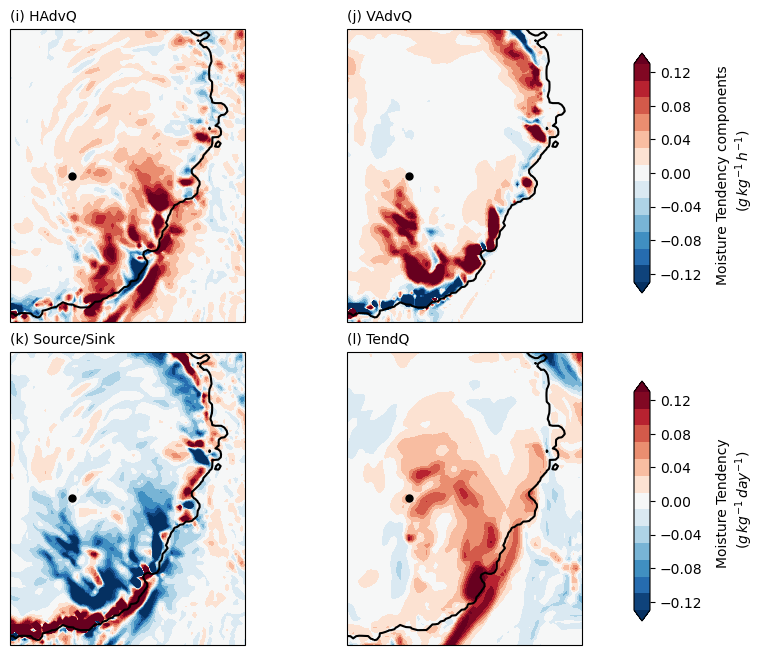

In [17]:
#############################################
# Plot Change in Moisture Tendency Equation components
#############################################

min_height = 10

time_ix_ini = np.where(times == np.datetime64('2022-03-15T00'))[0][0]
time_ix_end = np.where(times == np.datetime64('2022-03-18T00'))[0][0]
  
#################
### Plot Norm ###
#Figure and axis
fig = plt.figure(figsize=[8,8])
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, hspace= 0.1, wspace=0.1)

### Background
ax1 = fig.add_subplot(spec[0, 0], projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(spec[0, 1], projection=ccrs.SouthPolarStereo())
ax3 = fig.add_subplot(spec[1, 0], projection=ccrs.SouthPolarStereo())
ax4 = fig.add_subplot(spec[1, 1], projection=ccrs.SouthPolarStereo())

CS1 = ax1.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS2 = ax2.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS3 = ax3.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")
CS4 = ax4.contour(wrf.to_np(height), np.arange(10,9000,8000), cmap="gray", extend="both")

for ax in [ax1, ax2, ax3, ax4]:
    ax.plot(wrf.to_np(CON_xy)[0], wrf.to_np(CON_xy)[1], 'ko', markersize=5, color='k')
    #ax.plot(wrf.to_np(DDU_xy)[0], wrf.to_np(DDU_xy)[1], 'ko', markersize=5, color='k')
    #ax.plot(wrf.to_np(CIS_xy)[0], wrf.to_np(CIS_xy)[1], 'ko', markersize=5, color='k')

#Calculate difference between the beginning and the end of the event
AdvQ_sig2_hist_event = wrf.to_np(AdvQ_sig2_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(AdvQ_sig2_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))
VAdvQ_sig2_hist_event = wrf.to_np(VAdvQ_sig2_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(VAdvQ_sig2_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))
ResQ_sig2_hist_event = wrf.to_np(ResQ_sig2_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(ResQ_sig2_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))
TendQ_sig2_hist_event = wrf.to_np(TendQ_sig2_hist[time_ix_ini:time_ix_end,:,:].mean(axis=0)) - wrf.to_np(TendQ_sig2_past[time_ix_ini:time_ix_end,:,:].mean(axis=0))

fill1 = ax1.contourf(AdvQ_sig2_hist_event, np.arange(-.13,.14,0.02), cmap='RdBu_r', extend="both")
fill2 = ax2.contourf(VAdvQ_sig2_hist_event, np.arange(-.13,.14,0.02), cmap='RdBu_r', extend="both")
fill3 = ax3.contourf(ResQ_sig2_hist_event, np.arange(-.13,.14,0.02), cmap='RdBu_r', extend="both")
fill4 = ax4.contourf(TendQ_sig2_hist_event*8, np.arange(-.13,.14,0.02), cmap='RdBu_r', extend="both")

ax1.set_title('(i) HAdvQ', loc='left', fontsize=10)
ax2.set_title('(j) VAdvQ', loc='left', fontsize=10)
ax3.set_title('(k) Source/Sink', loc='left', fontsize=10)
ax4.set_title('(l) TendQ', loc='left', fontsize=10)

fig.subplots_adjust(right=0.93)
cbar_ax_1 = fig.add_axes([0.95, 0.55, 0.02, 0.3])
cbar_1 = fig.colorbar(fill1, cax=cbar_ax_1, orientation = 'vertical', shrink=0.5, pad=0)
cbar_1.set_label('Moisture Tendency components \n ($g\, kg^{-1}\, h^{-1}$)', labelpad=10)
cbar_1.set_ticks(np.arange(-0.12,0.13,0.04))

cbar_ax_2 = fig.add_axes([0.95, 0.14, 0.02, 0.3])
cbar_2 = fig.colorbar(fill4, cax=cbar_ax_2, orientation = 'vertical', shrink=0.5, pad=0)
cbar_2.set_label('Moisture Tendency \n ($g\, kg^{-1}\, day^{-1}$)', labelpad=10)
cbar_2.set_ticks(np.arange(-0.12,0.13,0.04))


for ax in [ax1, ax2, ax3, ax4]:
    ax.set_extent([140, 220, 30, 130], crs=ccrs.SouthPolarStereo())
    ax.contourf(np.where(np.isnan(ResQ_sig2_hist_event), 1, 0), [0.1, 1000], cmap='Greys')